(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import basic math
import LinearAlgebra

# Import package to work with pre-defined size arrays
import StaticArrays as SA

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Splines as smooth interpolators

In this notebook, we will define spines to smoothly interpolate between points.
The reason for this is that the existing packages in Julia do not satisfy our
needs. Thus, we must code our own cubic spline structure.

## Cubic curves

Let's begin working with a simple 1D cubic curve. Such curve takes the form
$$
x(t) = d t^3 + c t^2 + b t + a.
$$
Our objective is to find the coefficients $(a, b, c, d)$ to smoothly interpolate
the data. For example, let us say we have four points we want to smoothly
interpolate through.

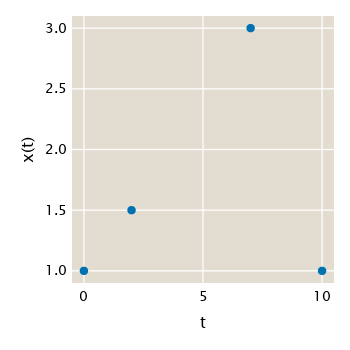

In [43]:
# Define points to interpolate through
x = [1, 1.5, 3, 1]
t = [0, 2, 7, 10]

# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot points
scatter!(ax, t, x)

fig

To interpolate through these points, we can define a matrix equation of the form
$$
\left[\begin{array}{cccc}
t_1^3 & t_1^2 & t_1 & 1 \\
t_2^3 & t_2^2 & t_2 & 1 \\
t_3^3 & t_3^2 & t_3 & 1 \\
t_4^3 & t_4^2 & t_4 & 1
\end{array}\right]\left[\begin{array}{l}
d \\
c \\
b \\
a
\end{array}\right]=\left[\begin{array}{l}
x_1 \\
x_2 \\
x_3 \\
x_4
\end{array}\right],
$$
where we simply need to invert the matrix with the time coefficients.

Let's define a `mutable struct` that contains both the anchoring points (the
x-values) and the time where they are evaluated. 

In [44]:
mutable struct CubicCurve
    c::SA.SVector{4, <:Real}
    t::SA.SVector{4, <:Real}
    coeff::SA.SVector{4, <:Real}

    # Define function for standard initialization of weights
    function CubicCurve(c, t)
        new(c, t, [0, 0, 0, 0])
    end # initialization function
end # mutable struct

curve = CubicCurve(x, t)

CubicCurve([1.0, 1.5, 3.0, 1.0], [0, 2, 7, 10], [0, 0, 0, 0])

Next, let's define a function that given a `CubicCurve`, solves the linear
system to find the coefficients.

In [45]:
function fit_cubic!(curve::CubicCurve)
    # Build matrix T̲̲
    T̲̲ = SA.SMatrix{4, 4}(
        hcat([t .^(0:3) for t in curve.t]...)'
    )
    # Solve system
    curve.coeff = T̲̲ \ curve.c
end # function

fit_cubic!(curve)

4-element StaticArraysCore.SVector{4, Float64} with indices SOneTo(4):
  1.0
  0.05654761904761898
  0.12232142857142847
 -0.012797619047619037

Let's define another function that evaluates the spline for a grid of points.

In [46]:
function eval_cubic(t::Vector{<:Real}, curve::CubicCurve)
    # Evaluate and return cubic curve
    [LinearAlgebra.dot(time .^(0:3), curve.coeff) for time in t]
end # function

eval_cubic (generic function with 1 method)

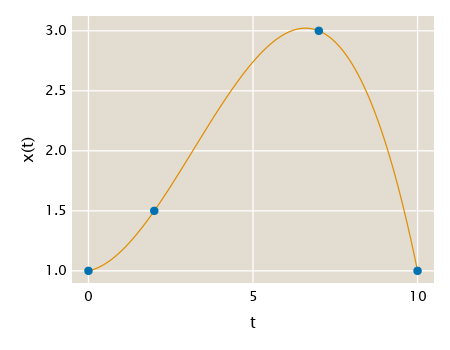

In [47]:
# Define time range
t_range = collect(0:0.1:maximum(curve.t))

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot spline
lines!(
    ax, 
    t_range, 
    eval_cubic(t_range, curve), 
    color=ColorSchemes.seaborn_colorblind[2]
)

# Plot points
scatter!(ax, t, x)

fig

## Tangential Cubic curves

Sometimes, it is simpler to specify two anchoring points and the slope of the
curve at these tangential points. Given the two equations coming from the
position of the anchoring points and the two equations from their tangential
lines, we can constrain the system to solve for the coefficients by solving the
matrix equation of the form
$$
\left[\begin{array}{cccc}
t_i^3 & t_i^2 & t_i & 1 \\
t_f^3 & t_f^2 & t_f & 1 \\
3 t_i^2 & 2 t_i & 1 & 0 \\
3 t_f^2 & 2 t_f & 1 & 0
\end{array}\right]\left[\begin{array}{l}
a \\
b \\
c \\
d
\end{array}\right]=\left[\begin{array}{l}
x_i \\
x_f \\
\dot{x}_i \\
\dot{x}_f
\end{array}\right]
$$

Let's define a curve and the desired tangents.

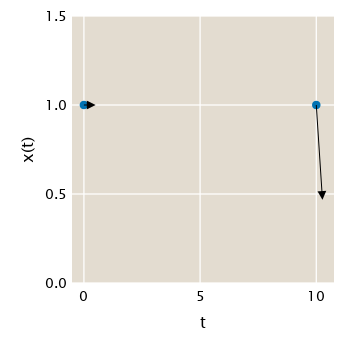

In [53]:
x = [1.0, 1.0]
ẋ = [0.0, -2.0]
t = [0.0, 10.0]

# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot points
scatter!(ax, t, x)

# Define scaling factor for arrows
scale = 0.25
# Add desired slopes
arrows!(ax, t, x, [1, 1] .* scale, ẋ .* scale)

ylims!(ax, [0, 1.5])
fig

As before, let's define a `mutable struct` for a cubic curve that will be fit
from the values of the derivatives.

In [54]:
mutable struct TangentCubicCurve
    c::SA.SVector{2, <:Real}
    dc::SA.SVector{2, <:Real}
    t::SA.SVector{2, <:Real}
    coeff::SA.SVector{4, <:Real}

    # Define function for standard initialization of weights
    function TangentCubicCurve(c, dc, t)
        new(c, dc, t, [0, 0, 0, 0])
    end # initialization function
end # mutable struct

curve = TangentCubicCurve(x, ẋ, t)

TangentCubicCurve([1.0, 1.0], [0.0, -2.0], [0.0, 10.0], [0, 0, 0, 0])

Likewise, let's define a function to fit the cubic curve given this information.
For this, we will take advantage of the multiple dispatch paradigm in Julia and
define the function with the same name as before.

In [64]:
function fit_cubic!(curve::TangentCubicCurve)
    # Build matrix T̲̲
    T̲̲ = SA.SMatrix{4, 4}(
        hcat(
            [
                [t .^(0:3) for t in curve.t]; # Anchor points
                [(0:3) .* t .^([0; collect(0:2)]) for t in curve.t] # derivatives
            ]...
        )'
    )
    # Solve system
    curve.coeff = T̲̲ \ [curve.c; curve.dc]
end # function

fit_cubic!(curve)

4-element StaticArraysCore.SVector{4, Float64} with indices SOneTo(4):
  1.0
  0.0
  0.2
 -0.02

We again define a function to evaluate the spline.

In [65]:
function eval_cubic(t::Vector{<:Real}, curve::TangentCubicCurve)
    # Evaluate and return cubic curve
    [LinearAlgebra.dot(time .^(0:3), curve.coeff) for time in t]
end # function

eval_cubic (generic function with 2 methods)

And plot the resulting curve.

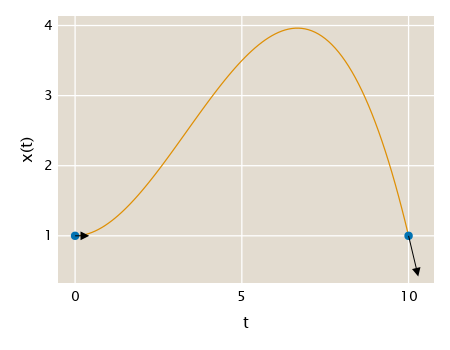

In [67]:
# Define time range
t_range = collect(0:0.1:maximum(curve.t))

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot spline
lines!(
    ax, 
    t_range, 
    eval_cubic(t_range, curve), 
    color=ColorSchemes.seaborn_colorblind[2]
)

# Plot points
scatter!(ax, t, x)

# Define scaling factor for arrows
scale = 0.25
# Add desired slopes
arrows!(ax, t, x, [1, 1] .* scale, ẋ .* scale)

fig

## Natural Cubic Spline

In [103]:
mutable struct CubicSpline
    x::VecOrMat{<:AbstractFloat}
    t::Vector{<:AbstractFloat}
    coeff::Vector{VecOrMat{<:AbstractFloat}}
    knot::Vector{Bool}

    # Define function to initialize with default values
    function CubicSpline(x, t)
        # Set defaul coefficients according to type
        if typeof(x) <: Vector
            # Set coefficients to zero
            coeff = zeros(4)
        elseif typeof(x) <: Matrix
            coeff = zeros(4, size(x, 1))
        end # if

        # Set default values
        new(
            x, # Use given anchor points
            t, # Use given time values
            repeat([coeff], length(x)-1), # Use defined coefficients
            (t .!= maximum(t)) .& (t .!= minimum(t)) # Check if point is knot
        )
    end # function
end # mutable struct

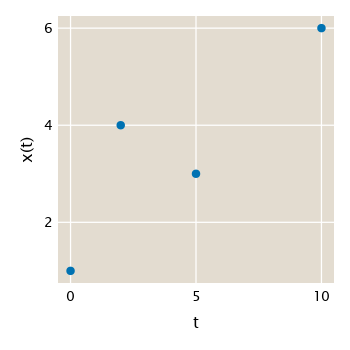

In [104]:
# Define points
t = Float64.([0, 2, 5, 10])
x = Float64.([1, 4, 3, 6])

# Define spline
spline = CubicSpline(x, t)

# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot points
scatter!(ax, spline.t, spline.x)

fig

Let's now define a function to fit a spline to the anchoring points

In [150]:
function fit_spline!(spline::CubicSpline)
    # Initialize matrix that defines coefficients
    T̲̲ = zeros(length(spline.coeff) * 4, length(spline.coeff) * 4)
    # Initialize vector of coefficients
    x̲ = zeros(length(spline.coeff) * 4)

    # Define coefficient indexes
    coeff_idx = [x:x+3 for x in 1:4:length(spline.coeff) * 4]

    # Initialize row counter
    count = 1

    # Loop through time points to add anchor point constraint
    for (i, t) in enumerate(spline.t)
        # Check if point is knot
        if spline.knot[i]
            # Set coefficients for anchor point constraint on left curve
            T̲̲[count, coeff_idx[i-1]] .= t .^(0:3)
            # Set vector value
            x̲[count] = spline.x[i]
            # Update counter
            count += 1
            # Set coefficients for anchor point constraint on right curve
            T̲̲[count, coeff_idx[i]] .= t .^(0:3)
            # Set vector value
            x̲[count] = spline.x[i]
            # Update counter
            count += 1
        elseif t == minimum(spline.t)
            # Set coefficients for anchor point constraint
            T̲̲[count, coeff_idx[i]] .= t .^(0:3)
            # Set vector value
            x̲[count] = spline.x[i]
            # Update counter
            count += 1
        elseif t == maximum(spline.t)
            # Set coefficients for anchor point constraint
            T̲̲[count, coeff_idx[i-1]] .= t .^(0:3)
            # Set vector value
            x̲[count] = spline.x[i]
            # Update counter
            count += 1
        end # if
    end # for

    # Loop through knot points to set derivative constraints
    for (j, t) in enumerate(spline.t)
        # Check if point is knot
        if spline.knot[j]
            # Set coefficients for first derivative constraint for left curve
            T̲̲[count, coeff_idx[j-1]] .= collect(0:3) .* t .^([0; collect(0:2)])
            # Set coefficients for first derivative for right curve
            T̲̲[count, coeff_idx[j]] .= - collect(0:3) .* t .^([0; collect(0:2)])
            # Update counter
            count += 1
            # Set coefficients for second derivative constraint for left curve
            T̲̲[count, coeff_idx[j-1]] .= [0.0, 0.0, 2.0, 6.0*t]
            # Set coefficients for second derivative constraint for right curve
            T̲̲[count, coeff_idx[j]] .= - [0.0, 0.0, 2.0, 6.0*t]
            # Update counter
            count += 1
        elseif t == minimum(spline.t)
            # Set coefficients for second derivative constraint for left curve
            T̲̲[count, coeff_idx[j]] .= - [0.0, 0.0, 2.0, 6.0*t]
            # Update counter
            count += 1
        elseif t == maximum(spline.t)
            # Set coefficients for second derivative constraint for left curve
            T̲̲[count, coeff_idx[j-1]] .= [0, 0, 2, 6*t]
        end # if
    end # for

    # Compute coefficients by solving system
    coeffs = T̲̲ \ x̲

    spline.coeff = [coeffs[x] for x in coeff_idx]
end # function

@time fit_spline!(spline)

  0.000155 seconds (165 allocations: 9.781 KiB)


3-element Vector{Vector{Float64}}:
 [1.0, 1.9256070640176601, -0.0, -0.10640176600441503]
 [-0.6806475349521719, 4.446578366445917, -1.2604856512141283, 0.10367917586460634]
 [14.735099337748355, -4.802869757174394, 0.5894039735099338, -0.019646799116997793]

Let's define a function to evaluate the cubic spline.

In [148]:
function eval_spline(t::Vector{T}, spline::CubicSpline) where T <: Real
    # Initialize array where to save evaluation
    x = Vector{T}(undef, length(t))

    # Loop through time intervals
    for i = 2:length(spline.t)
        # Locate all points in first segment
        idx = spline.t[i-1] .≤ t .≤ spline.t[i]
        # Evaluate and cubic curve
        x[idx] = [
            LinearAlgebra.dot(time .^(0:3), spline.coeff[i-1]) for time in t[idx]
        ]
    end # for 

    return x
end # function

eval_spline (generic function with 1 method)

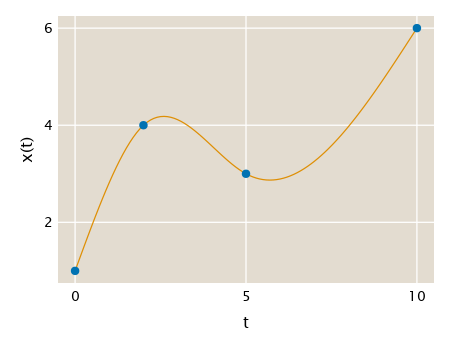

In [149]:
# Define time range
t_range = collect(0:0.1:maximum(spline.t))

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="t",
    ylabel="x(t)",
)

# Plot spline
lines!(
    ax, 
    t_range, 
    eval_spline(t_range, spline), 
    color=ColorSchemes.seaborn_colorblind[2]
)

# Plot points
scatter!(ax, spline.t, spline.x)

fig